In [3]:
import numpy as np
import pandas as pd
import folium
import imageio
import matplotlib
from collections import Counter
import matplotlib.pyplot as plt
from folium import plugins
from folium.plugins import HeatMap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from graphviz import Source
from sklearn import tree

In [4]:
data = pd.read_csv("../../../Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")
data.Date = pd.to_datetime(data.Date)
data['Hour'] = pd.to_datetime(data.Time).dt.hour
data['DayOfWeek'] = data.Date.dt.dayofweek
data['Month'] = data.Date.dt.month
data['Minutes'] = pd.to_datetime(data.Time).dt.minute
data['Year'] = pd.to_datetime(data.Time).dt.year
data['X'] = data['X'].astype(float)
data['Y'] = data['Y'].astype(float)

In [5]:
#Check and remove missing values
is_NaN = data.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = data[row_has_NaN]
print(len(rows_with_NaN))
data = data.drop(rows_with_NaN.index)

1


# Week 7

## Before the intro: COVID-19 thoughts and visualizations

Hey All,

So wow. It's a new reality. I made my [little video last week](https://www.youtube.com/watch?v=gLjLCQQSzwk), but creating it on Monday night I was only a little bit early. The following Wednesday evening, the Danish government took pretty decisive action. 

On the whole, I agree with this course of action, and I encourage you to respect the government's guidelines. Practice social distancing. You know the deal. 

And let's me also draw a line to a recent excellent visualization. There's an absolutely amazing visualization in the Washington Post, which uses dataviz to illustrate why the social distancing is a useful strategy.

> https://www.washingtonpost.com/graphics/2020/world/corona-simulator/

And another really nice one from NYT about `#flattenthecurve`

> https://www.nytimes.com/interactive/2020/03/13/opinion/coronavirus-trump-response.html

And if you didn't see it the [3blue1brown video on exponential growth](https://youtu.be/Kas0tIxDvrg), that's also fantastic (as is pretty much everything from that guy).


## The intro

Anyway. I'm sure you guys have a lot to do this week, so we'll try to keep it relatively light (although there should be enough optional exercises to keep you all busy).

Remember that last week you worked with 2 different ways to classify data: *KNN*'s and *Decisions Trees*. We are going to continue working with Decision Trees and see how new information can influence the performance of our model in predicting which type of crime happened.

Specifically, crimes can have many causes, so we can combine datasouces to better understand what makes a criminal commit a crime. Are there specific factors which trigger that individual to act? Since criminals are notoriously shy about sharing information, we must try to find this out in a different way. Lucky for us, we can do this with data! *We are going to use weather data* from San Franciso to try to relate different crimes with meteorological conditions!

* We'll start with a relatively simple exercise focusing adding weather data to the decision tree from last week (Part 1, 2, and 3).
* Then we'll prepare a bit for next week, when we get into the topic of explanatory data visualization with some lectures and reading (Part 4)
* And finally, we'll have some advanced excercises if you can't get enough of the first exercise (Part 5).



## Part 1: Create a Baseline

Before we begin adding new data, lets do somethings similar to last week and build a Decision Tree/Random Forest classifier to predict the category of a crime with the help of our friend `sklearn` using the following variables:

* `Hour of the week` (`1 , 2, ..., 168 `). 
* `PD District` (`TENDERLOIN`, etc).  (**Remember**, You'll need to encode this  labels as integers in `sklearn`, you can just assign numbers to the labels with something like sklearn's `Label Encoder` or do your own custom function). 
  * **Hint**: as we have discussed on Slack, instead of directly assigning a label to a number, you can encode your data using a *one hot encoding*. Essentially this is a way to avoid computers to establish a hierarchy/order between values of a certain variable when it does not exist, as is our case for PD District since its values are just names of Districts. Here's a [nice explanation](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd) about the topic.

This model will function as our baseline. Once we have it set up, we can use it to understand how adding variables from our weather dataset will influence the decisions of the tree later on.

In [6]:
data['HourOfTheWeek'] = data.Hour + (data.DayOfWeek) * 24

In [7]:
#OneHotEncode PdDistrict
data.PdDistrict = pd.Categorical(data['PdDistrict'])
pddummies = pd.get_dummies(data['PdDistrict'], prefix = 'pddistrict')
data = pd.concat([data, pddummies], axis=1)

In [8]:
pd_columns = list(pddummies.columns.values)

Since we will use weather data, let's try to think of crime categories that our intuition tells us might be strongly influenced by the weather conditions (type 1). And also think of other categories where we **don't** expect weather to play a role (type 2). We suggest:

* `BURGLARY or VEHICLE THEFT` for type 1. 
* `FORGERY/COUNTERFEITIN or FRAUD` for type 2. 

Feel free to explore other pairs that you find reasonable in this context.


> *Exercise*: Build the decision tree!
> * Remember to keep the data you used for training (since if you are following our recommendations it will be taken at random) so we can use it later on when we add the weather data (as was mentioned last week, build a **balanced training dataset**). We recommed you build a separate Pandas `Dataframe` with it, so the process of adding the weather data will be as smooth as possible later on. The same goes for your testing data.
> * Create a function to evaluate the precision of your classifier. Make sure your test data is not used for training.
> 
> Additional ML-refinements (Optional):
> * If you find yourself with extra time, come back to this exercise and tweak the variables you use to see if you can improve the accuracy of the tree. Try for example adding Year, Month or other variables you think may be relevant.
> * Does one hot encoding affect your results? Compare the results you get with the different encoding techniques you use for PD District.
> * Are your results tied to the specific training data you used? Are you overfitting? Try performing [cross-validation](https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f) to answer this question.

In [9]:
data.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,...,pddistrict_BAYVIEW,pddistrict_CENTRAL,pddistrict_INGLESIDE,pddistrict_MISSION,pddistrict_NORTHERN,pddistrict_PARK,pddistrict_RICHMOND,pddistrict_SOUTHERN,pddistrict_TARAVAL,pddistrict_TENDERLOIN
0,110308742,MISSING PERSON,FOUND PERSON,4,2011-04-15,16:00,TARAVAL,LOCATED,0 Block of CRESPI DR,-122.476328,...,0,0,0,0,0,0,0,0,1,0
1,90316914,WARRANTS,WARRANT ARREST,3,2009-03-26,12:28,SOUTHERN,"ARREST, BOOKED",1000 Block of MARKET ST,-122.411340,...,0,0,0,0,0,0,0,1,0,0
2,130132311,SECONDARY CODES,DOMESTIC VIOLENCE,4,2013-02-15,02:00,PARK,"ARREST, BOOKED",CASTRO ST / MARKET ST,-122.435188,...,0,0,0,0,0,1,0,0,0,0
3,80052833,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",1,2008-01-15,20:13,MISSION,"ARREST, CITED",VALENCIA ST / 16TH ST,-122.421886,...,0,0,0,1,0,0,0,0,0,0
4,70535770,SECONDARY CODES,DOMESTIC VIOLENCE,5,2007-05-26,18:10,MISSION,"ARREST, BOOKED",2800 Block of FOLSOM ST,-122.413935,...,0,0,0,1,0,0,0,0,0,0


In [10]:
crime1 = "BURGLARY"
crime2 = "FORGERY/COUNTERFEITING"

samplesizepercat = min(len(data[data.Category == crime1]),len(data[data.Category == crime2]))

In [11]:
crime1sample = data[data.Category == crime1].sample(n=samplesizepercat)
crime2sample = data[data.Category == crime2].sample(n=samplesizepercat)
dtcrimedata = pd.concat([crime1sample, crime2sample])

In [12]:
#columns to use from data
datacols = ['Date', 'Hour','HourOfTheWeek', 'Category']
datacols += pd_columns
dtcrimedata = dtcrimedata[datacols]
dtcrimedata

,Date,Hour,HourOfTheWeek,Category,pddistrict_BAYVIEW,pddistrict_CENTRAL,pddistrict_INGLESIDE,pddistrict_MISSION,pddistrict_NORTHERN,pddistrict_PARK,pddistrict_RICHMOND,pddistrict_SOUTHERN,pddistrict_TARAVAL,pddistrict_TENDERLOIN
403834,2005-12-27,6,30,BURGLARY,0,0,0,0,1,0,0,0,0,0
1744188,2004-09-01,7,55,BURGLARY,1,0,0,0,0,0,0,0,0,0
1215154,2017-06-07,4,52,BURGLARY,0,0,0,1,0,0,0,0,0,0
565930,2007-11-25,1,145,BURGLARY,0,0,0,0,1,0,0,0,0,0
12756,2005-06-26,16,160,BURGLARY,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650054,2005-03-21,13,13,FORGERY/COUNTERFEITING,0,0,0,0,0,0,0,0,1,0
673644,2003-10-03,0,96,FORGERY/COUNTERFEITING,0,0,0,0,0,0,0,1,0,0
2114138,2008-06-17,0,24,FORGERY/COUNTERFEITING,0,0,0,0,0,0,0,1,0,0
2160119,2007-09-27,13,85,FORGERY/COUNTERFEITING,0,0,0,0,0,1,0,0,0,0


In [13]:
X = dtcrimedata.drop(['Date', 'Hour', 'Category'], axis=1)
y = dtcrimedata.Category
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [14]:
y_predict = clf.predict(X_test)

In [15]:
def evaluate_classifier(y_test, y_predict):
    return ((y_predict == y_test).sum() / len(y_test) * 100)

In [16]:
f"{evaluate_classifier(y_test, y_predict)}%"

'65.58864129363045%'

## Part 2: Predict Crimes with Weather Data

Time to get that weather data rolling. The raw data we are using can be found online [here](https://www.meteoblue.com/en/weather/archive/export/san-francisco_united-states-of-america_5391959) or [you can get a convenient version from the files folder our class repository by clicking here](https://raw.githubusercontent.com/suneman/socialdataanalysis2020/master/files/Data_files/weather_data.csv). 

> *Exercise*
> 
> * Load the weather dataset. If you have your training data and test data on separate `DataFrames` then merging them with the weather information should be simple 
>   * **Hint**: you can use the join method from pandas. To do so, you will need to round the time to the hour because weather data is recorded hourly. Also it's fine to drop missing values. Here's a [stackoverflow post](https://stackoverflow.com/questions/36292959/pandas-merge-data-frames-on-datetime-index) which may help you. 
>  * *Note*: you'll need to do some encoding on the weather data as before if you want to use the weather column. Also, check if all of the entries of the new training data have indeed a weather part to them. 
> * Now that you have the data properly merged, you can **fit a new random forest on the data and compare the results**. How does the weather data influence the prediction performances? (Use the evaluation function you built above.) Is there as impact in the accuracy of predictions? Is weather data relevant for the predictions?
> * *Optional*: Try experimenting with using only certain variables of the weather data. Can you improve the performance of classification by using fewer features/variables?


In [17]:
weather_data = pd.read_csv("../../weather_data.txt")
weather_data.date = pd.to_datetime(weather_data.date)
weather_data

,date,temperature,humidity,weather,wind_speed,wind_direction,pressure
0,2012-10-01 13:00:00+00:00,16.330000,88.0,light rain,2.0,150.0,1009.0
1,2012-10-01 14:00:00+00:00,16.324993,87.0,sky is clear,2.0,147.0,1009.0
2,2012-10-01 15:00:00+00:00,16.310618,86.0,sky is clear,2.0,141.0,1009.0
3,2012-10-01 16:00:00+00:00,16.296243,85.0,sky is clear,2.0,135.0,1009.0
4,2012-10-01 17:00:00+00:00,16.281869,84.0,sky is clear,2.0,129.0,1009.0
...,...,...,...,...,...,...,...
44301,2017-10-27 20:00:00+00:00,23.910000,28.0,sky is clear,0.0,277.0,1015.0
44302,2017-10-27 21:00:00+00:00,25.990000,25.0,sky is clear,2.0,0.0,1014.0
44303,2017-10-27 22:00:00+00:00,27.410000,22.0,sky is clear,2.0,0.0,1014.0
44304,2017-10-27 23:00:00+00:00,27.910000,20.0,sky is clear,2.0,120.0,1013.0


In [18]:
dtcrimedata['date'] = dtcrimedata.Date +  pd.to_timedelta(dtcrimedata.Hour, unit='h')
dtcrimedata['date'] = pd.to_datetime(dtcrimedata["date"].dt.strftime('%B %d, %Y, %r'))
weather_data['date'] = pd.to_datetime(weather_data["date"].dt.strftime('%B %d, %Y, %r'))

In [19]:
dtcrimedata.head()

,Date,Hour,HourOfTheWeek,Category,pddistrict_BAYVIEW,pddistrict_CENTRAL,pddistrict_INGLESIDE,pddistrict_MISSION,pddistrict_NORTHERN,pddistrict_PARK,pddistrict_RICHMOND,pddistrict_SOUTHERN,pddistrict_TARAVAL,pddistrict_TENDERLOIN,date
403834,2005-12-27,6,30,BURGLARY,0,0,0,0,1,0,0,0,0,0,2005-12-27 06:00:00
1744188,2004-09-01,7,55,BURGLARY,1,0,0,0,0,0,0,0,0,0,2004-09-01 07:00:00
1215154,2017-06-07,4,52,BURGLARY,0,0,0,1,0,0,0,0,0,0,2017-06-07 04:00:00
565930,2007-11-25,1,145,BURGLARY,0,0,0,0,1,0,0,0,0,0,2007-11-25 01:00:00
12756,2005-06-26,16,160,BURGLARY,0,0,0,0,0,1,0,0,0,0,2005-06-26 16:00:00


In [20]:
crimeweather = pd.merge(dtcrimedata, weather_data, on='date', how="inner")
crimeweather

,Date,Hour,HourOfTheWeek,Category,pddistrict_BAYVIEW,pddistrict_CENTRAL,pddistrict_INGLESIDE,pddistrict_MISSION,pddistrict_NORTHERN,pddistrict_PARK,...,pddistrict_SOUTHERN,pddistrict_TARAVAL,pddistrict_TENDERLOIN,date,temperature,humidity,weather,wind_speed,wind_direction,pressure
0,2017-06-07,4,52,BURGLARY,0,0,0,1,0,0,...,0,0,0,2017-06-07 04:00:00,17.100000,73.0,mist,4.0,10.0,1011.0
1,2013-08-13,16,40,BURGLARY,1,0,0,0,0,0,...,0,0,0,2013-08-13 16:00:00,16.650000,85.0,mist,1.0,182.0,1014.0
2,2015-06-16,13,37,BURGLARY,0,0,1,0,0,0,...,0,0,0,2015-06-16 13:00:00,12.104667,99.0,sky is clear,1.0,195.0,1025.0
3,2017-08-19,0,120,BURGLARY,0,0,0,0,0,0,...,0,0,0,2017-08-19 00:00:00,24.540000,82.0,haze,3.0,230.0,1015.0
4,2016-12-23,6,102,BURGLARY,0,0,0,0,1,0,...,0,0,0,2016-12-23 06:00:00,6.180000,87.0,mist,2.0,290.0,1016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,2012-11-11,10,154,FORGERY/COUNTERFEITING,1,0,0,0,0,0,...,0,0,0,2012-11-11 10:00:00,7.990000,66.0,scattered clouds,3.0,280.0,1016.0
11533,2015-05-28,16,88,FORGERY/COUNTERFEITING,0,0,0,0,1,0,...,0,0,0,2015-05-28 16:00:00,12.901667,94.0,light rain,1.0,208.0,1029.0
11534,2014-02-27,18,90,FORGERY/COUNTERFEITING,0,0,0,1,0,0,...,0,0,0,2014-02-27 18:00:00,14.080000,82.0,few clouds,5.0,220.0,1012.0
11535,2013-02-07,14,86,FORGERY/COUNTERFEITING,0,0,0,0,0,0,...,0,1,0,2013-02-07 14:00:00,5.790000,81.0,scattered clouds,1.0,260.0,1022.0


In [21]:
#Check and remove missing values
is_NaN = crimeweather.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = crimeweather[row_has_NaN]
print(len(rows_with_NaN))
crimeweather = crimeweather.drop(rows_with_NaN.index)

1


In [22]:
weather = pd.get_dummies(crimeweather.weather, prefix = 'weather')
crimeweather = pd.concat([crimeweather.drop(["weather"], axis=1), weather], axis=1)
crimeweather

,Date,Hour,HourOfTheWeek,Category,pddistrict_BAYVIEW,pddistrict_CENTRAL,pddistrict_INGLESIDE,pddistrict_MISSION,pddistrict_NORTHERN,pddistrict_PARK,...,weather_proximity thunderstorm with rain,weather_scattered clouds,weather_sky is clear,weather_smoke,weather_squalls,weather_thunderstorm,weather_thunderstorm with heavy rain,weather_thunderstorm with light rain,weather_thunderstorm with rain,weather_very heavy rain
0,2017-06-07,4,52,BURGLARY,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-08-13,16,40,BURGLARY,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2015-06-16,13,37,BURGLARY,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,2017-08-19,0,120,BURGLARY,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2016-12-23,6,102,BURGLARY,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,2012-11-11,10,154,FORGERY/COUNTERFEITING,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
11533,2015-05-28,16,88,FORGERY/COUNTERFEITING,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11534,2014-02-27,18,90,FORGERY/COUNTERFEITING,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11535,2013-02-07,14,86,FORGERY/COUNTERFEITING,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [23]:
X = crimeweather.drop(['Date','date', 'Hour', 'Category'], axis=1)
y = crimeweather.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [24]:
X_train

,HourOfTheWeek,pddistrict_BAYVIEW,pddistrict_CENTRAL,pddistrict_INGLESIDE,pddistrict_MISSION,pddistrict_NORTHERN,pddistrict_PARK,pddistrict_RICHMOND,pddistrict_SOUTHERN,pddistrict_TARAVAL,...,weather_proximity thunderstorm with rain,weather_scattered clouds,weather_sky is clear,weather_smoke,weather_squalls,weather_thunderstorm,weather_thunderstorm with heavy rain,weather_thunderstorm with light rain,weather_thunderstorm with rain,weather_very heavy rain
2129,110,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8400,45,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
11536,164,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8268,78,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5419,104,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11285,94,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5191,57,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5390,164,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
860,103,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
f"{evaluate_classifier(y_test, y_predict)}%"

'61.702127659574465%'

## Part 3: A Simple Visualization

Now that you're done with the Machine Learning lets get to the fun part: Visualizations!

> *Exercise*: A map movie.
> * Remember week 2 and those wonderful shapefiles? Go back and get the code you did for that week. 
> * Now the goal is to plot a SF map for each hour of the week (that's 168 plots total, so you'd better set up a script to do it). **The maps should visualize the predictions you generated by the random forest classifier**.
>   * **Hint 0**: The output from the classifier can be thought of as a probability that *in some precinct at some time* we will observe either a crime of type 1 or type 2. Since the two probabilities sum to 1, we can map this to a [color gradient](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html).  
>   * **Hint 1**: You can use the method `predict_proba` from `sklearn` to output probabilities instead of classes from your decision tree classifier. This allows to use the map with a color gradient representing the probabilities of the crimes. 
>   *  **Hint 2**: Based on the data you feed to the Random Forest, you can use the average prediction of the all the datapoints you used for each specific district to create the visualization). 
> * Finally, create a GIF with all the maps you have drawn (from the 1st point) to display the entire week. To do so, first save each figure separatly and then load all the image and create a GIF. This can be done with `imageio` library in python. 
>   * **Hint 3**: Check out the following code to help with you (which assumes you've saved all files in a sub-directory called `Frames` with names `0.png`, `1.png`, ..., `167.png`, i.e. one frame per hour of the week).

In [26]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import urllib3
import json
import subprocess
%matplotlib inline
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(10,6))

In [27]:
shp_path = "./destination_data.shp"
sf = shp.Reader(shp_path)

In [28]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [29]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

In [30]:
def calc_color_old(data, color=None):
        if color   == 1: 
            color_sq = ['#dadaebFF','#bcbddcF0','#9e9ac8F0',
                        '#807dbaF0','#6a51a3F0','#54278fF0']; 
            colors = 'Purples';
        elif color == 2: 
            color_sq = ['#c7e9b4','#7fcdbb','#41b6c4',
                        '#1d91c0','#225ea8','#253494']; 
            colors = 'YlGnBu';
        elif color == 3: 
            color_sq =['#f7f7f7','#d9d9d9','#bdbdbd',
                        '#969696','#636363','#252525']; 
            colors = 'Greys';
        elif color == 9:
            color_sq =['#ff0000','#ff0000','#ff0000',
                        '#ff0000','#ff0000','#ff0000']
        else:   
            color_sq =['#ffffd4','#fee391','#fec44f',
                        '#fe9929','#d95f0e','#993404']; 
            colors = 'YlOrBr';
        new_data, bins = pd.qcut(data, 6, retbins=True, 
        labels=list(range(6)))
        color_ton = []
        for val in new_data:
            color_ton.append(color_sq[val]) 
        if color != 9:
            colors = sns.color_palette(colors, n_colors=6)
            sns.palplot(colors, 0.6);
            for i in range(6):
                print ("\n"+str(i+1)+': '+str(int(bins[i]))+
                       " => "+str(int(bins[i+1])-1), end =" ")
            print("\n\n   1   2   3   4   5   6")    
        return color_ton, bins;

In [31]:
def calc_color(data, color=None):
        cmap = matplotlib.cm.get_cmap('bwr')
        color_ton = []
        for val in data:
            color_ton.append(matplotlib.colors.rgb2hex(cmap(val)))  
        return color_ton;

In [64]:
def plot_map_fill_multiples_ids_tone(sf, title, comuna,  
                                     print_id, color_ton,
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''
        
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
            
    for id in comuna:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon,y_lat, color_ton[comuna.index(id)])
        if print_id != False:
            x0 = np.mean(x_lon)
            y0 = np.mean(y_lat)
            plt.text(x0, y0, id, fontsize=10)
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)
    return plt

In [60]:
def plot_district_data(sf, title, comunas, data=None, 
                      color=None, print_id=False):
    '''
    Plot map with selected comunes, using specific color
    '''
    
    color_ton = calc_color(data, color)
    df = read_shapefile(sf)
    comuna_id = []
    for i in comunas:
        comuna_id.append(df[df.DISTRICT == 
                            i.upper()].index.to_numpy()[0])
    return plot_map_fill_multiples_ids_tone(sf, title, comuna_id, 
                                     print_id, 
                                     color_ton,
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (11,9));

In [61]:
def get_probs(probs, classes):
    tot = 0
    prob1 = 0
    prob2 = 0
    for prob in probs:
        tot += 1
        prob1 += prob[0]
        prob2 += prob[1]
    return dict(zip(classes, [prob1/tot, prob2/tot]))

In [62]:
def get_probs_per_district_and_hourofweek(district, hourofweek):
    X_test_district = X_test[(X_test.HourOfTheWeek==hour) & (X_test["pddistrict_"+district] == 1)]
    if(len(X_test_district) == 0):
        return dict(zip(clf.classes_, [0,0]))
    return get_probs(clf.predict_proba(X_test_district), clf.classes_)

In [36]:
def fromHourOfWeekToDayAndHour(hourofweek):
    weekDays = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    return f"{weekDays[int(hourofweek/24)]}: {hourofweek%24}:00"

In [37]:
for hour in range(0,168):
    dist_prob = {}
    for district in data.PdDistrict.unique():
        dist_prob[district] = get_probs_per_district_and_hourofweek(district, hour)[clf.classes_[0]]
    plt = plot_district_data(sf,fromHourOfWeekToDayAndHour(hour),dist_prob.keys(),pd.Series(dist_prob),1,True)
    plt.savefig(f"./Frames/{hour}.png")
    plt.clf()
    plt.close()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

<Figure size 792x648 with 0 Axes>

ADD LEGEND
https://matplotlib.org/3.1.1/gallery/ticks_and_spines/colorbar_tick_labelling_demo.html

In [38]:
import os
images = []
files = os.listdir('./Frames')

for filename in range(len(files)-1):
    if filename != '.ipynb_checkpoints':
        images.append(imageio.imread('./Frames/' + str(filename)+ '.png'))
kargs = { 'duration': 1 }
imageio.mimsave('./crime_evo_rain.gif', images, 'GIF', **kargs )

In [39]:
from IPython.display import HTML
HTML('<img src="./crime_evo_rain.gif">')

dist_prob = {}
hour = 1
for district in data.PdDistrict.unique():
    dist_prob[district] = get_probs_per_district_and_hourofweek(district, hour)[clf.classes_[0]]
print(dist_prob)
plot_district_data(sf,fromHourOfWeekToDayAndHour(hour),dist_prob.keys(),pd.Series(dist_prob),1,True)

## Part 4: Video Lectures and Reading

Next week we'll be playing around with *explanatory data visualization*. Roughly speaking this means using data visualization to communicate your results to others. Thus, there are new things to think about. We'll start thinking about that already this week.

We start with a video from from yours truly and then read a bit from a scientific article about types of explanatory dataviz.

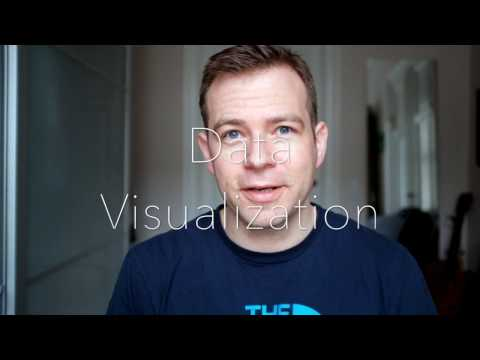

In [40]:
# Sune talks about designing visualizations.
from IPython.display import YouTubeVideo
YouTubeVideo("yHKYMGwefso",width=600, height=338)

> *Exercises*: Explanatory data visualization
> * What are the three key elements to keep in mind when you design an explanatory visualization?
Start with a question -> find the result you want to communicate
Allow for exploration in order to engage the user and allowing him to deeply understand the result as he explores
Know your readers (what is their level of knowledge of the topic/statistics ..)
> * In the video I talk about (1) *overview first*,  (2) *zoom and filter*,  (3) *details on demand*. 
>   - Go online and find a visualization that follows these principles (don't use one from the video). 
>   - Explain how it does achieves (1)-(3). It might be useful to use screenshots to illustrate your explanation.
> * Explain in your own words: How is explanatory data analysis different from exploratory data analysis?

*Reading*: [Narrative Visualization: Telling Stories with Data](http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf) by Edward Segel and Jeffrey Heer. We'll read sectin 1-3 today. (And the rest next time).

When you get to section 3 it's fun to open up the examples mentioned by the authors in a browser and explore them as you read the text. 

> *Exercise*: Answer a couple of questions about the paper.
> 
> * What is the *Oxford English Dictionary's* defintion of a narrative?
an account of a
series of events, facts, etc., given in order and with the establishing of
connections between them
> * What is your favorite visualization among the examples in section 3? Explain why in a few words.
My favorite is the one from the White House budget forecast. A good example of zoom and filter!

## Part 5: Optional (But Cool )Visualizations

The aim here is to create an animated map that shows empirical data for *two* crimes that change patterns with weather alongside the associated prediction. Pierre has looked at `DRUG/NARCOTIC` AND `BURGLARY`. 

The steps are
* *Empirical data plots*. Here you take the raw data and simply tally up the observed crimes hour-by-hour. In order to compare the two crime-types which don't have identical counts, you should convert your hourly counts to hourly probabilities. Simply divide your precinct-counts by the total number of counts that hour. It is OK to use lots of aggregated data for this one.
* Now, build a random forest classifier for your crimes which doesn't take weather into account. Again, you may train the classifier on as much data as you like.
* Next, build a classifier which knows about weather (lot of tips and tricks available above). 

Now we're getting closer, let's visualize how actual weather impacts our predictions. Since we need weather, we're going to have to pick a specific week (you're free to choose something different than what's on the plot below).
* For each hour of that specific week, plot the visualization of the precinct-probabilities that come out of you random forest model without weather.
* The plot the same probabilities **with** weather.
* Finally tile all those plots side by side and create a gif so you can inspect the patterns.
* Describe in your own words the impact of the weather data. Does it change the model predicitons?

See below for Pierre's version. 

![Movie](https://github.com/suneman/socialdataanalysis2020/raw/master/files/crime_evo_rain-min.gif "movie")

Finally **big thanks** to TA's Pierre and Joao for big help in developing the exercises this week. I've been busy with all kinds of COVID related chores and I simply could not have done it without them.